In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from VAE_OPTIMIZATION_WD import _dataset, VAE, study, compare_continuous, compare_integer#, compare_distributions_binned_aux, compare_distributions_binned

[I 2021-08-02 09:07:49,867] Using an existing study with name 'Optimizing the VAE with WD - BKG vs Random Sampling' instead of creating a new one.


## Loading the Study

In [2]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 100
Best trial:
  Value: 6.630528688507764
  Params: 
    alpha: 6561
    hidden_size: 28
    lr: 0.00043266173297886026
    n_layers_decoder: 12
    n_layers_encoder: 4
    n_units_decoder_l0: 265
    n_units_decoder_l1: 475
    n_units_decoder_l10: 285
    n_units_decoder_l11: 85
    n_units_decoder_l2: 325
    n_units_decoder_l3: 385
    n_units_decoder_l4: 215
    n_units_decoder_l5: 265
    n_units_decoder_l6: 445
    n_units_decoder_l7: 75
    n_units_decoder_l8: 405
    n_units_decoder_l9: 445
    n_units_encoder_l0: 190
    n_units_encoder_l1: 20
    n_units_encoder_l2: 480
    n_units_encoder_l3: 20
 TRIAL NUMBER: 83


### Optuna Graphs

In [3]:
optuna.visualization.plot_param_importances(study) 

In [4]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [5]:
# Nao é o 49, 53, 33, 26, 25, 23, 22, 16
#name = "wd-sample_vs_data_trial_16"
#name = "wd-sample_vs_data_trial_{}".format(trial.number)
name = f"CustomTrain_WD-Data_vs_Sampling_trial_{trial.number}"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[16], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=47, out_features=190, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=190, out_features=20, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=20, out_features=480, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=480, out_features=20, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=20, out_features=28, bias=True)
  )
  (hidden2mu): Linear(in_features=28, out_features=28, bias=True)
  (hidden2log_var): Linear(in_features=28, out_features=28, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=28, out_features=265, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=265, out_features=475, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=475, out_features=325, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=325, ou

### Load data

In [6]:
# Bkg
bkg = _dataset(category='test',variant='bkg').all_data()
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(334164, 47)

## Check if z ~ N(0,1)

In [7]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(334164, 28)

<ipython-input-8-cccee3f30eb4>:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



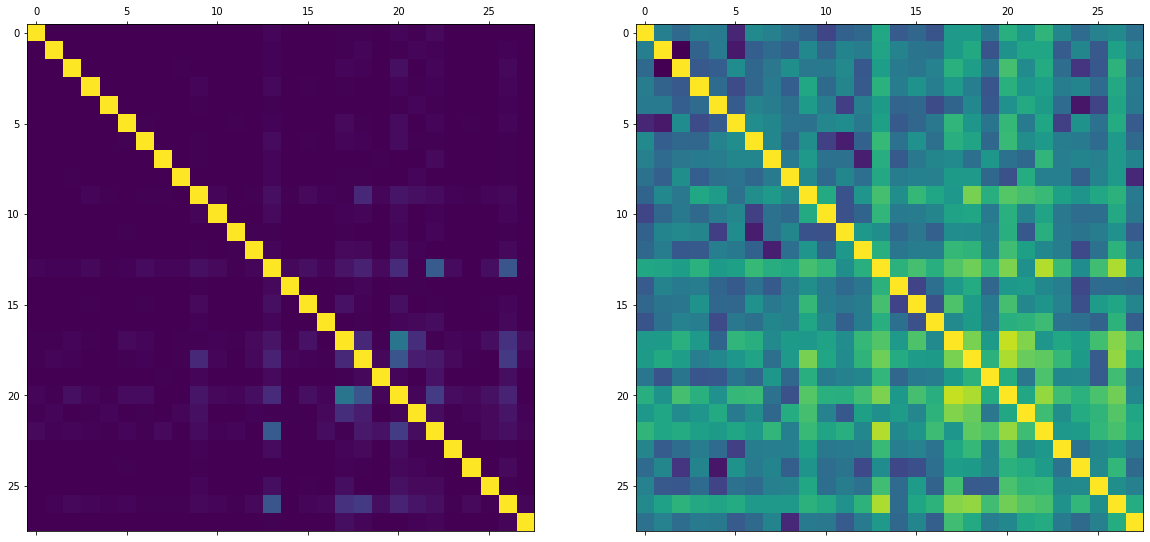

In [8]:
fig = plt.figure(figsize=[20,15])
i = 0

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs))

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs).apply(np.log))
fig.show()

In [9]:
corr = pd.DataFrame(hidden).corr().apply(abs)
corr.replace(1, 0, inplace=True)

print("Max:\t", round(corr.max().max(), 5))
print("Mean:\t", round(corr.mean().mean(), 5))

Max:	 0.38884
Mean:	 0.01369


Mean: 0.0004283684 	Std: 0.8565895
Mean: -0.008461015 	Std: 0.8361421
Mean: 0.0036442874 	Std: 0.8323015
Mean: 0.0038455762 	Std: 0.8470631
Mean: -0.008010339 	Std: 0.8452305
Mean: -0.0054665143 	Std: 0.8303118
Mean: -0.0011704915 	Std: 0.8516547
Mean: 0.02221522 	Std: 0.83334756
Mean: -0.010437714 	Std: 0.843029
Mean: -0.075494014 	Std: 0.98446524
Mean: -0.016854651 	Std: 0.8443128
Mean: 0.0030141505 	Std: 0.8484496
Mean: 0.010797265 	Std: 0.8177801
Mean: 0.22773567 	Std: 1.2886117
Mean: 0.017510017 	Std: 0.8408564
Mean: 0.0073672766 	Std: 0.8405279
Mean: 0.0079051275 	Std: 0.83585036
Mean: -0.05461182 	Std: 0.9827132
Mean: 0.19638266 	Std: 0.9795877
Mean: -0.0157588 	Std: 0.8261281
Mean: 0.22007023 	Std: 1.3039957
Mean: 0.0029785573 	Std: 0.9776716
Mean: -0.47865465 	Std: 1.5239617
Mean: 0.008865551 	Std: 0.83613485
Mean: -0.0069436557 	Std: 0.8315004
Mean: -0.0037853757 	Std: 0.8218801
Mean: -0.24225032 	Std: 1.4222972
Mean: -0.002080638 	Std: 0.85451543


<ipython-input-10-ac97c69f04a6>:14: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



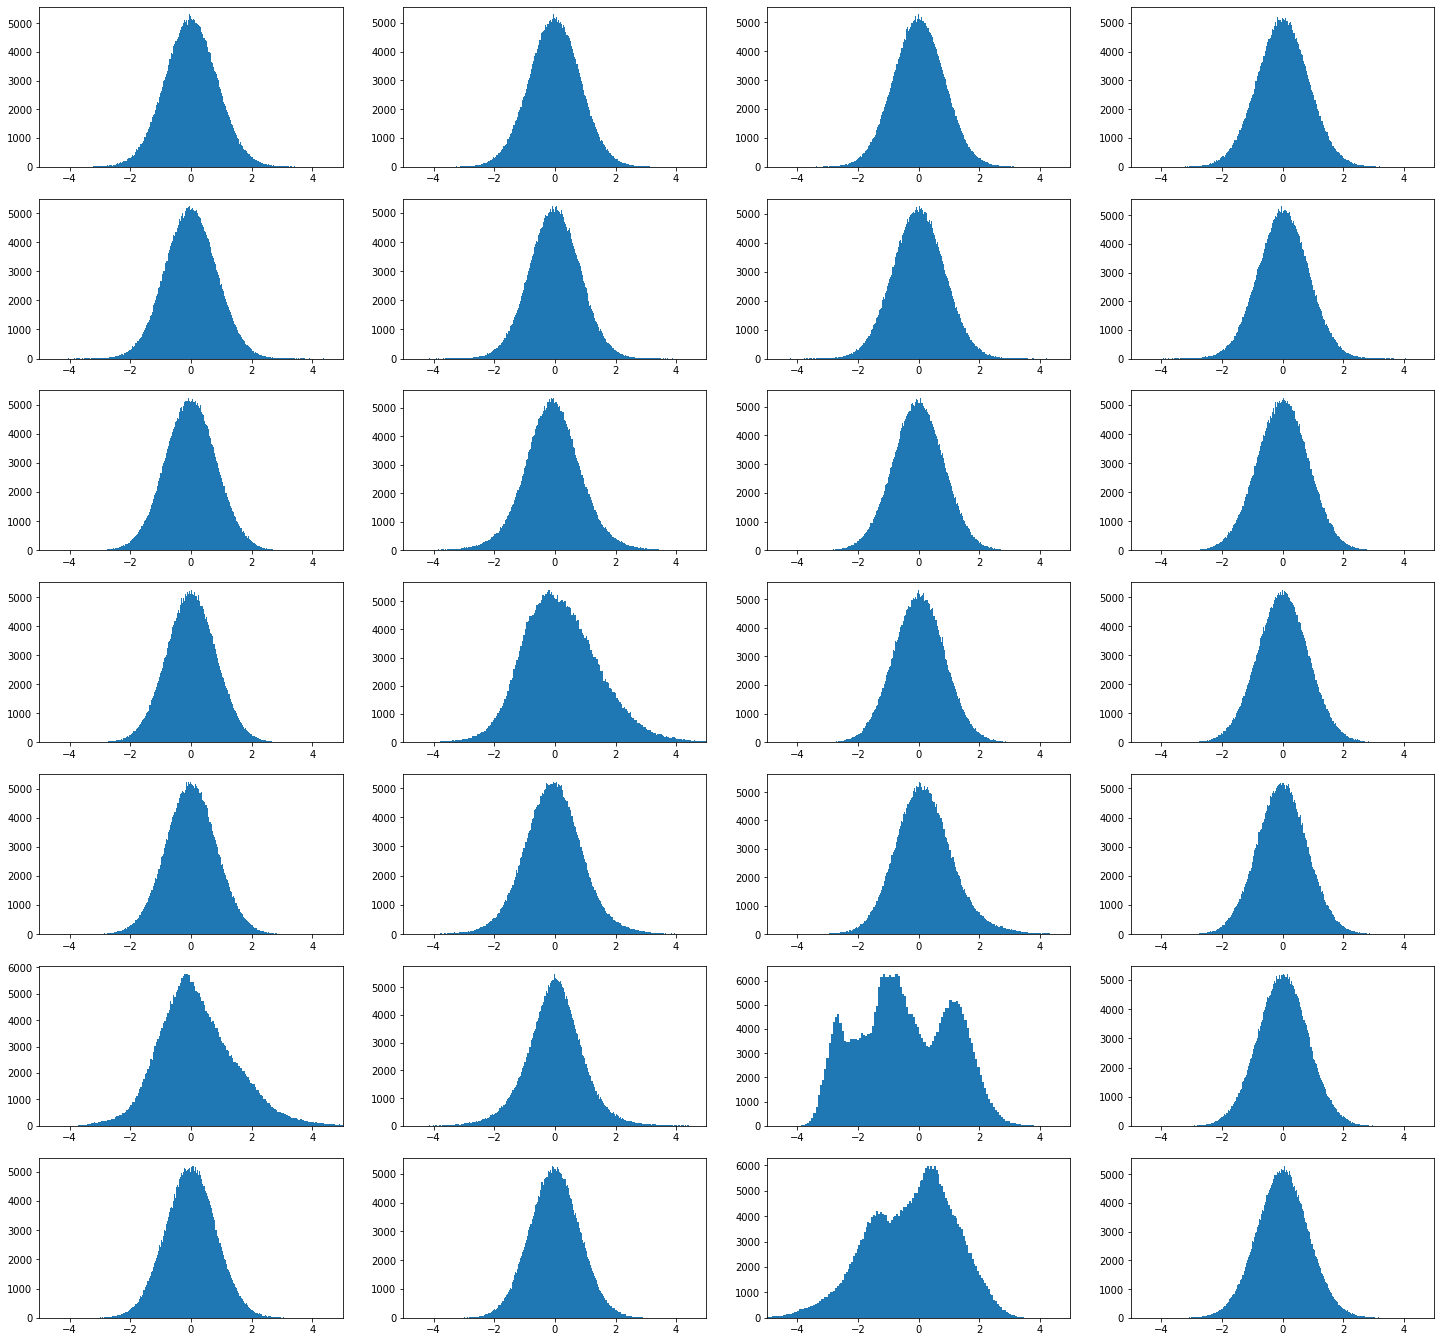

In [10]:

fig = plt.figure(figsize=[25,70])
i = 0

total_mean = []
total_std = []
for x in range(hidden.shape[1]):
    axes = fig.add_subplot(20,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    total_mean.append(hidden[:, x].mean())
    total_std.append(hidden[:, x].std())
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())

print("\n")
print("Total average mean", np.array(total_mean).mean())
print("Total average std", np.array(total_std).mean())
fig.show()

## Bkg Data vs Random Sampling Decoding

In [11]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,Lepton1_Eta,Lepton1_PT,Lepton1_Phi,Lepton2_Eta,Lepton2_PT,Lepton2_Phi,MissingET_MET,MissingET_Phi,Muon_Multi,ScalarHT_HT
count,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,...,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000
mean,-0.428751,-0.945496,0.577425,-0.367440,-0.127197,0.672585,-0.176204,-0.225957,-0.239970,-0.246704,...,-1.042919,-0.190407,-0.896131,-1.010203,0.153987,0.133967,0.145533,-0.389600,0.414035,-0.249081
std,0.568975,1.442619,0.518397,0.364509,0.937865,0.547592,0.353079,0.387849,0.397399,0.396183,...,1.293772,0.368506,0.328403,1.227265,0.502159,0.805491,0.499812,0.622032,0.567575,0.386247
min,-0.926306,-3.325452,-1.315059,-1.012292,-3.448531,-1.146834,-0.917662,-1.052402,-1.085098,-1.099444,...,-3.328957,-1.104723,-2.170426,-3.289584,-1.166007,-2.060022,-0.798795,-3.103443,-1.322108,-0.968318
25%,-0.859586,-2.171585,0.487646,-0.619456,-0.860267,0.575242,-0.423777,-0.501080,-0.524770,-0.533815,...,-2.111183,-0.453533,-1.095223,-2.027982,-0.235338,-0.361328,-0.204666,-0.803442,-0.238973,-0.522625
50%,-0.841852,-1.669790,0.660935,-0.475501,-0.269996,0.811319,-0.162824,-0.220710,-0.238585,-0.249959,...,-1.702228,-0.224184,-0.862150,-1.618559,0.072977,0.092651,0.033000,-0.397117,0.825198,-0.357846
75%,0.227355,0.474314,0.860822,-0.227134,0.825367,1.004389,0.076462,0.046331,0.036235,0.027378,...,0.250644,0.011519,-0.703645,0.222999,0.455528,0.788317,0.392076,0.020513,0.843790,-0.081296
max,1.307717,2.830792,2.217389,1.886359,1.757375,2.062469,2.126231,1.147880,1.217093,1.240928,...,2.008262,2.127891,1.225065,1.923778,2.942154,1.945669,4.498290,2.184452,0.905820,1.731947


In [12]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="Sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

        #WD_SCORE += wasserstein_distance(background[x], signal[x])
        #R2_SCORE += r2_score(background[x],signal[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()

In [13]:
plot_graphs2(bkg, sample)

Processing...:   0%|          | 0/47 [00:00<?, ?it/s]

In [1]:
objective_score = 0
for idx in range(bkg.shape[1]):
    feature = bkg.columns[idx]
    if "Tag" in feature or "Multi" in feature:
        #print("Feature", feature, "é inteiro")
        objective_score += compare_integer(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
    else:
        #print("Feature", feature, "é continuo")
        objective_score += compare_continuous(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
print("WD Score:", objective_score)

NameError: name 'bkg' is not defined

## Bkg Data vs Reconstruction

In [ ]:
def plot_graphs3(first, second, first_name="Signal", second_name="Sampled", bins=50, num_cols=4, num_features=69):

    R2_SCORE = 0

    # Reshape
    first = first.reshape(num_features, -1)
    second = second.reshape(num_features, -1)

    # Plot creation
    num_rows = int(np.ceil((num_features - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(range(num_features), total=num_features, desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(first[x].min(), second[x].min())
        hist_max = max(first[x].max(), second[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(first[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(second[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)

        x = x.cpu().numpy()
        output = output.cpu().numpy()

        #print("Input", np.isnan(x).any())
        #print("Output", np.isnan(output).any())


        #R2_SCORE += r2_score(first[x],second[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    #print("R2_SCORE:", R2_SCORE/num_features)

In [ ]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="Reconstruction")

In [ ]:
print("R2 Score:", r2_score(bkg.to_numpy(), x_out, sample_weight=bkg_weights.to_numpy()))

## Plot error distributions and ROC Scores

Load data

In [ ]:
bkg = _dataset(category='test',variant='bkg').all_data()
signal = _dataset(category='all',variant='signal').all_data()
# signal.drop(columns=['weights'], inplace=True)

data = pd.concat([signal, bkg])
del signal, bkg

Plot

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_graphs3(data, bins=50, num_cols=4):
    # Plot creation
    features = list(data['name'].unique())

    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        ## Get the relevant data
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        ## Pass input through model to get the output
        _, _, output, _ = model.test_step(sData)

        ## Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    # Now we are going to find the maximum of all distributions
    max_of_dist = max(map(lambda x: max(x), distributions.values()))

    # Normalize the distributions
    # This way all values should be between 0 and 1
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    
    ## Plot error distributions
    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2, density=True)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range, density=True)

    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    ## Plot ROC Curves
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            # Set Scores
            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 

            # Set weights
            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            # Get Curve
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            print(f"ROC SCORE for {x.replace('.h5', '')}:", 
                    roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights))

    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()

In [ ]:
plot_graphs3(data)